In [1]:
import numpy as np
import skimage.io
import skimage.draw
import json
from skimage.draw import polygon
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import os
import pandas as pd
import cv2

In [92]:

image_path= "E:\\ribs\\np\\img\\"
mask_path = "E:\\ribs\\np\\mask\\"
df_img=[]
df_mask=[]
for i in range(1,196):
    img=np.load(image_path + str(i)+ '.npy')
    img=resize(img,(256,256,3))
    df_img.append(img)
    mask = np.load(mask_path + str(i)+ '.npy')
    mask=resize(mask,(256,256,1))
    df_mask.append(mask)

In [93]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

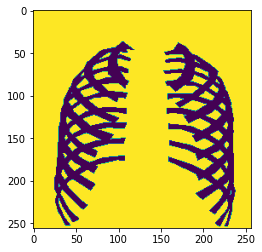

In [6]:
plt.imshow(df_mask[0])

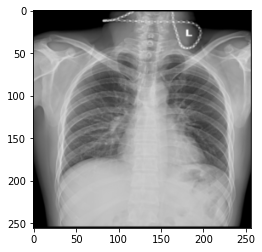

In [8]:
plt.imshow(df_img[0])

In [95]:
X=(np.array(df_img))
Y=(np.array(df_mask))
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.20, random_state=42)

In [ ]:
y_train.shape

In [20]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [23]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [86]:
def se_block(x,r):
    copy=x
    print(copy.shape)
    gap=layers.GlobalAveragePooling2D()(x)
    flat=layers.Flatten()(gap)
    print(flat.shape[-1])
    print(flat.shape)
    print(r)
    dense=layers.Dense(flat.shape[-1]//r, activation = 'relu')(gap)
    print(dense.shape)
    dense=layers.Dense(flat.shape[-1], activation = 'sigmoid')(dense)
    print(dense.shape)
    m =layers.multiply([dense,copy])
    return m

In [77]:

def resb(x, filter_size, size, dropout,num, batch_norm=False):
    # copy tensor to variable called x_skip
    x_skip = x
    x_skip=layers.Conv2D(1, (1, 1), padding="same")(x_skip)
    print(x_skip.shape)
    # Layer 1
    x = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation("relu")(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    print(x.shape)
    # Layer 2
    x = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation("relu")(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    print(x.shape)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [78]:
def conv_block(x, filter_size, size, dropout,num, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same",name="conv"+str(num))(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [79]:
def mb_block(x, filter_size, size, dropout,num, batch_norm=False):
    
    conv = layers.Conv2D(size, (1,1), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    dwconv = layers.DepthwiseConv2D(size, (filter_size,filter_size), padding="same")(conv)
    if batch_norm is True:
        dwconv = layers.BatchNormalization(axis=3)(dwconv)
    dwconv = layers.Activation("relu")(dwconv)
    
    conv = layers.Conv2D(size, (1,1), padding="same",name="conv"+str(num))(dwconv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
        
    conv = layers.Conv2D(size, (1,1), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    dwconv = layers.DepthwiseConv2D(size, (filter_size,filter_size), padding="same")(conv)
    if batch_norm is True:
        dwconv = layers.BatchNormalization(axis=3)(dwconv)
    dwconv = layers.Activation("relu")(dwconv)
    
    conv = layers.Conv2D(size, (1,1), padding="same",name="conv"+str(num))(dwconv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [80]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [128]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
def Attention_UWNet_v2(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, 0.2, 1, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, 0.2, 2, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM,0.2, 3, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM,0.2,4, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, 0.2,5, batch_norm)
    
    print(conv_8.shape)
    # W-net layers
    attw_16 = se_block(conv_16, 8*FILTER_NUM)
    upw_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    upw_16 = layers.concatenate([upw_16, attw_16], axis=3)
    up_convw_16 = resb(upw_16, FILTER_SIZE, 8*FILTER_NUM, 0.2,6, batch_norm)
    print(up_convw_16.shape)

    poolw_8 = layers.MaxPooling2D(pool_size=(2,2))(up_convw_16)
    convw_16 = conv_block(poolw_8, FILTER_SIZE, 16*FILTER_NUM, 0.2,7, batch_norm)
    print(convw_16.shape)
    
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    att_16 = se_block(up_convw_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(convw_16)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, 0.2,8, batch_norm)
    # UpRes 7
    att_32 = se_block(conv_32,  4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 =conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate,9, batch_norm)
    # UpRes 8
    att_64 = se_block(conv_64,  2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, 0.2,10, batch_norm)
    # UpRes 9
    att_128 = se_block(conv_128,  FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, 0.2,11, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UWNet")
    return model

In [126]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
def Attention_UWNet_v2(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 16 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, 0.2, 1, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, 0.2, 2, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM,0.2, 3, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, 0.2,4, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, 0.2,5, batch_norm)
    
    print(conv_8.shape)
    # W-net layers
    gatingw_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    attw_16 = attention_block(conv_16, gatingw_16, 8*FILTER_NUM)
    upw_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    upw_16 = layers.concatenate([upw_16, attw_16], axis=3)
    up_convw_16 = resb(upw_16, FILTER_SIZE, 8*FILTER_NUM, 0.2,6, batch_norm)
    print(up_convw_16.shape)

    poolw_8 = layers.MaxPooling2D(pool_size=(2,2))(up_convw_16)
    convw_16 = conv_block(poolw_8, FILTER_SIZE, 16*FILTER_NUM, 0.2,7, batch_norm)
    print(convw_16.shape)
    
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(convw_16, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(up_convw_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(convw_16)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, 0.2,8, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 =conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, 0.2,9, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, 0.2,10, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, 0.2,11, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UWNet")
    return model

In [164]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
def Attention_UWNet_v2(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, 0.2, 1, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, 0.2, 2, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM,0.2, 3, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM,0.2,4, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = resb(pool_8, FILTER_SIZE, 16*FILTER_NUM, 0.2,5, batch_norm)
    
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    att_16 = se_block(conv_8, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, 0.2,8, batch_norm)
    # UpRes 7
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 =conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate,9, batch_norm)
    # UpRes 8
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, 0.2,10, batch_norm)
    # UpRes 9
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, 0.2,11, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UWNet")
    return model

In [49]:
131072/(32*32)

128.0

In [165]:
from tensorflow.keras import backend as K

ra_unet=Attention_UWNet_v2((256,256,3),dropout_rate=0.0, batch_norm=True)
ra_unet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

(None, 16, 16, 1)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
512
(None, 512)
256
(None, 2)
(None, 512)


In [166]:
results=ra_unet.fit(x_train,y_train,validation_data=(x_val, y_val),batch_size=8,epochs=80)

Epoch 1/80
20/20 [==============================] - 6s 131ms/step - loss: 0.6129 - accuracy: 0.7210 - val_loss: 0.7015 - val_accuracy: 0.5558
Epoch 2/80
20/20 [==============================] - 2s 107ms/step - loss: 0.5298 - accuracy: 0.8260 - val_loss: 0.7252 - val_accuracy: 0.3565
Epoch 3/80
20/20 [==============================] - 2s 107ms/step - loss: 0.5023 - accuracy: 0.8457 - val_loss: 0.6727 - val_accuracy: 0.6888
Epoch 4/80
20/20 [==============================] - 2s 107ms/step - loss: 0.4795 - accuracy: 0.8641 - val_loss: 0.5681 - val_accuracy: 0.7811
Epoch 5/80
20/20 [==============================] - 2s 108ms/step - loss: 0.4619 - accuracy: 0.8764 - val_loss: 0.6230 - val_accuracy: 0.7131
Epoch 6/80
20/20 [==============================] - 2s 108ms/step - loss: 0.4511 - accuracy: 0.8818 - val_loss: 0.5748 - val_accuracy: 0.7699
Epoch 7/80
20/20 [==============================] - 2s 108ms/step - loss: 0.4372 - accuracy: 0.8905 - val_loss: 0.5554 - val_accuracy: 0.7810
Epoch 

In [149]:
ra_unet.load_weights('ribs.h5')

In [ ]:
ima = resize(skimage.io.imread("E:\\Attention UW-Net-20230220T132847Z-001\\Attention UW-Net\\train_image\\images\\93.png"),(128,128,3))
ima=(1-(ra_unet.predict((ima).reshape(1,128,128,3),verbose=1))[0,:,:,0])
plt.imshow((ima>0.60).astype(np.uint8),cmap='gray')
plt.axis('off')

# test

In [97]:
image_path= "E:\\ribs\\np\\test_img\\"
mask_path = "E:\\ribs\\np\\test_mask\\"
df_img1=[]
df_mask1=[]
for i in range(49):
    img1=np.load(image_path + str(i)+ '.npy')
    img1=resize(img1,(256,256,3))
    df_img1.append(img1)
    mask1 = np.load(mask_path + str(i)+ '.npy')
    mask1=resize(mask1,(256,256,1))
    df_mask1.append(mask1)

In [167]:
pred_n=[]

for i in range(len(df_img1)):
    p=ra_unet.predict(df_img1[i].reshape(1,256,256,3),verbose=1)
    thres=(p[0,:,:,:]>0.60).astype(np.uint8)
    pred_n.append(thres)

1/1 [==============================] - 0s 17ms/step


In [168]:
plt.imshow(df_img[195],cmap='gray')
plt.axis("off")

IndexError: list index out of range

(-0.5, 255.5, 255.5, -0.5)

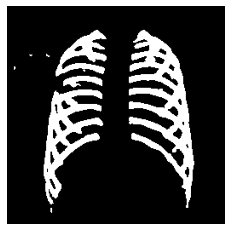

In [169]:
plt.imshow(1-pred_n[6][:,:,0],cmap='gray')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

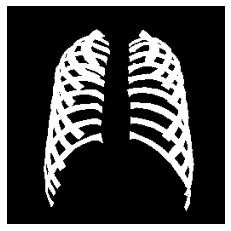

In [170]:
plt.imshow(1-df_mask1[6],cmap='gray')
plt.axis("off")

In [172]:
Y_pred=(1-pred_n[6]).astype(np.uint8).flatten()
Y_val=(1-df_mask1[6]).astype(np.uint8).flatten()
(TN,FP,FN,TP)= confusion_matrix(y_true=Y_val,y_pred=Y_pred,labels=[0, 1]).ravel()
sensitivity=TP/(TP+FN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)  
f1=2*(precision*recall)/(precision+recall)
specificity=TN/(TN+FP)
miou=TP/(TP+FP+FN)

In [173]:
f1

0.8757787994671937

In [108]:
f

[79.94876045512771,
 80.81474177246395,
 83.34260533481685,
 86.39089338347394,
 69.55400696864112,
 84.68489706113469,
 86.27618640444635,
 83.50880645478696,
 87.02461511184657,
 87.59734093067426,
 76.2106102911847,
 76.87833252544837,
 82.14337020543026,
 85.93322386425834,
 79.34011618576884,
 80.55745124097554,
 81.7603362040901,
 84.09321175278622,
 79.1405550581916,
 86.81878182161041,
 89.6987441251252,
 83.6530578783407,
 87.67551922399969,
 83.76876699373449,
 82.82388774067226,
 80.06408142109974,
 82.36185383244207,
 74.66943057256825,
 81.11580726965343,
 83.92233552172091,
 85.28643944887601,
 82.34245158529191,
 83.08870937156294,
 82.42580955530835,
 86.45274340159894,
 86.45470765450875,
 85.24322651436287,
 82.871271076524,
 85.80278781621062,
 84.10078192875761,
 86.38457921955806,
 85.67414908250169,
 82.14009287925697,
 86.54154268711376,
 85.29627407851763,
 82.52528412052965,
 78.91156462585033,
 86.26010892886615,
 82.31038126981547]

In [155]:
from sklearn.metrics import confusion_matrix
import statistics
sp=[]
sn=[]
pr=[]
rec=[]
f=[]
iou=[]
for i in range(len(df_img1)):
  Y_pred=(1-pred_n[i]).astype(np.uint8).flatten()
  Y_val=(1-df_mask1[i]).astype(np.uint8).flatten()
  (TN,FP,FN,TP)= confusion_matrix(y_true=Y_val,y_pred=Y_pred,labels=[0, 1]).ravel()
  sensitivity=TP/(TP+FN)
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)  
  f1=2*(precision*recall)/(precision+recall)
  specificity=TN/(TN+FP)
  miou=TP/(TP+FP+FN)
  if np.isnan(sensitivity):
    sn.append(100)
  else:
      sn.append(sensitivity*100)
  if np.isnan(precision):
    pr.append(100)
  else:
      pr.append(precision*100)
  if np.isnan(recall):
      rec.append(100)
  else:
      rec.append(recall*100)
  if np.isnan(f1):
    f.append(100)
  else:
    f.append(f1*100)
  if np.isnan(miou):
    iou.append(100)
  else:
    iou.append(miou*100)


In [174]:
statistics.stdev(f)

4.2068358367489935

In [157]:
sum(iou)/len(iou)

75.30422671747044

In [175]:
sum(f)/len(f)

85.77211538149562

In [163]:
statistics.stdev(rec)

6.732926676498061